In [1]:
import MDAnalysis as mda
from MDAnalysis.auxiliary import EDR
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.align as align
import MDAnalysis.analysis.hydrogenbonds
import MDAnalysis.analysis.diffusionmap as diffusionmap
import ipywidgets as widgets
from ipywidgets import Box

import numpy as np

# Import viewer
import nglview
import ipywidgets

# Import matplotlib - for plotting data
import matplotlib.pyplot as plt
# Import statistics Library
import statistics

#other general things
import warnings
import os


## Inputs

### Inputs files and options

In [2]:
calculate_RMSD = widgets.Checkbox(value=True, description='Calculate RMSD',disabled=False,indent=False)
align_traj = widgets.Checkbox(value=True, description='Align Trajectory',disabled=False,indent=False)
radius_of_gyration = widgets.Checkbox(value=True,description='Calculate Radius of Gyration',disabled=False,indent=False)
calculate_RMSF = widgets.Checkbox(value=True,description='Calculate RMSF',disabled=False,indent=False)
pairwise_RMSD =  widgets.Checkbox(value=False,description='Calculate Pairwise RMSD',disabled=False,indent=False)
optionbox = Box(children=[calculate_RMSD,align_traj,radius_of_gyration,calculate_RMSF,pairwise_RMSD])
optionbox

Box(children=(Checkbox(value=True, description='Calculate RMSD', indent=False), Checkbox(value=True, descripti…

In [22]:
### Needed input
sim_path = 'D:\hAHR-ITE\GROMACS-hAHR\Wt-MCT\\'
ligand_name = "MCT" #set to None if no ligand
coordinate_file_name = 'md550ns.gro'             ##tpr or gro file tpr needed for h bond
trajectory_file_name = 'md550ns_center.xtc'      ##xtc file
auxiliary_file_name = 'md550ns.edr'              ##edr file
reference_structure_path = 'npt.gro'

sim_name = 'default' ##output pdb file will use thise name, if set to "default" will use the auxilliary file name

#Options

RMSD_groups = ["284 to 400" , "400 to 426" ]
RMSD_groups_name = ["Core" , "C-term" ]


H_bonds = False
start_frame = 100
stop_frame = None

edr_only = False



if sim_name == 'default':
    sim_name = auxiliary_file_name.split(".")[0]

RMSD_groups_name.insert(0, "Overall")


### Reading and preprocessing

In [5]:

## Read the diferent files
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    if not edr_only:
        reference_structure = mda.Universe(sim_path + reference_structure_path,)
        if os.path.isfile(sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc"): ## read the aligned file if it exist
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
            print("Aligned file found, reading this instead")
            is_aligned = True
        else:
            atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
            is_aligned = False
    energy_like_terms = EDR.EDRReader(sim_path + auxiliary_file_name)

def do_trajectory_CAalignement():
    average = align.AverageStructure(atomistic_system, atomistic_system, select='protein and name CA', ref_frame=0)
    print("Calculating averaged structure:")
    average.run(verbose=True)
    averaged_ref = average.results.universe
    # Align all structure on the averaged one
    aligner = align.AlignTraj(atomistic_system, 
                                  averaged_ref, 
                                  select='protein and name CA',
                                  in_memory=False,
                                  filename=sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    
    print("align trajectory on the averaged one, save as " + sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    aligner.run(verbose=True)

if align_traj:
    atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name)
    do_trajectory_CAalignement()
    atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
    is_aligned = True



Calculating averaged structure:


  0%|          | 0/55001 [00:00<?, ?it/s]

align trajectory on the averaged one, save as D:\hAHR-ITE\GROMACS-hAHR\Wt-BZP\md550ns_center_aligned.xtc


  0%|          | 0/55001 [00:00<?, ?it/s]

## Sanity Check
Check that simulation isn't going wrong, read temperature and pressure through the EDR <br>
list of the available data can be obtained with: <br>


In [6]:
## Def some plotting functions
def plt_median(ax,array, n=1, positive=True, negative=True, label=False, inside=False):
    # plt median and +- stdev
    median = statistics.median(array)
    stdev = statistics.stdev(array[2:]) #skip 2 1st frame
    
    if label:
        if inside:
            ax.text(x=0.05, y=0.15, ha="left", va="top", s=f"Median = {median:.2f}\nStdev = {stdev:.2f}", transform = ax.transAxes)        
        else:
            ax.text(x=0, y=-0.07, ha="left", va="top", s=f"Median = {median:.2f}\nStdev = {stdev:.2f}", transform = ax.transAxes)


    ax.axhline(y = median, color = 'r', linestyle = '-', alpha = 0.5)
    if positive:
        ax.axhline(y = median + n*stdev, color = 'r', linestyle = '-', alpha=0.2)
    if negative:
        ax.axhline(y = median - n*stdev, color = 'r', linestyle = '-', alpha =0.2)
    
    return median, stdev

def plt_smooth(ax,data_array,time_array,window):
    ## Use convolution to smooth an array on a sliding window anď plot it on the ax plot
    avg = np.convolve(data_array, np.ones(window)/window, mode='valid')
    slice_start = int(window/2-1)
    slice_finish = int(window/2)
    ax.plot(time_array[slice_start:-slice_finish]/1000, avg, label= str(window) + "ps avg")

def edr_plot(ax1, data_label, unit=False):
    #get data
    edr_data = energy_like_terms.get_data(data_label)

    #plot data
    ax1.plot(edr_data['Time']/1000, edr_data[data_label], label = "Instant")

    # Plt axis
    ax1.set_xlabel('Time (ns)')
    if unit:
        ylabel = f"{data_label} ({unit})"
    else:
        ylabel = data_label
    ax1.set_ylabel(ylabel)

    ax1.set_title(data_label)

    plt_smooth(ax1,edr_data[data_label],edr_data['Time'],20)
    median, stdev = plt_median(ax1,edr_data[data_label], label = True, inside = True)

    # Set axis limits
    ax1.set_ylim(median - 5 * stdev, median + 5 * stdev)
    if not edr_only:
        ax1.set_xlim(0, len(edr_data['Time'])/100)    

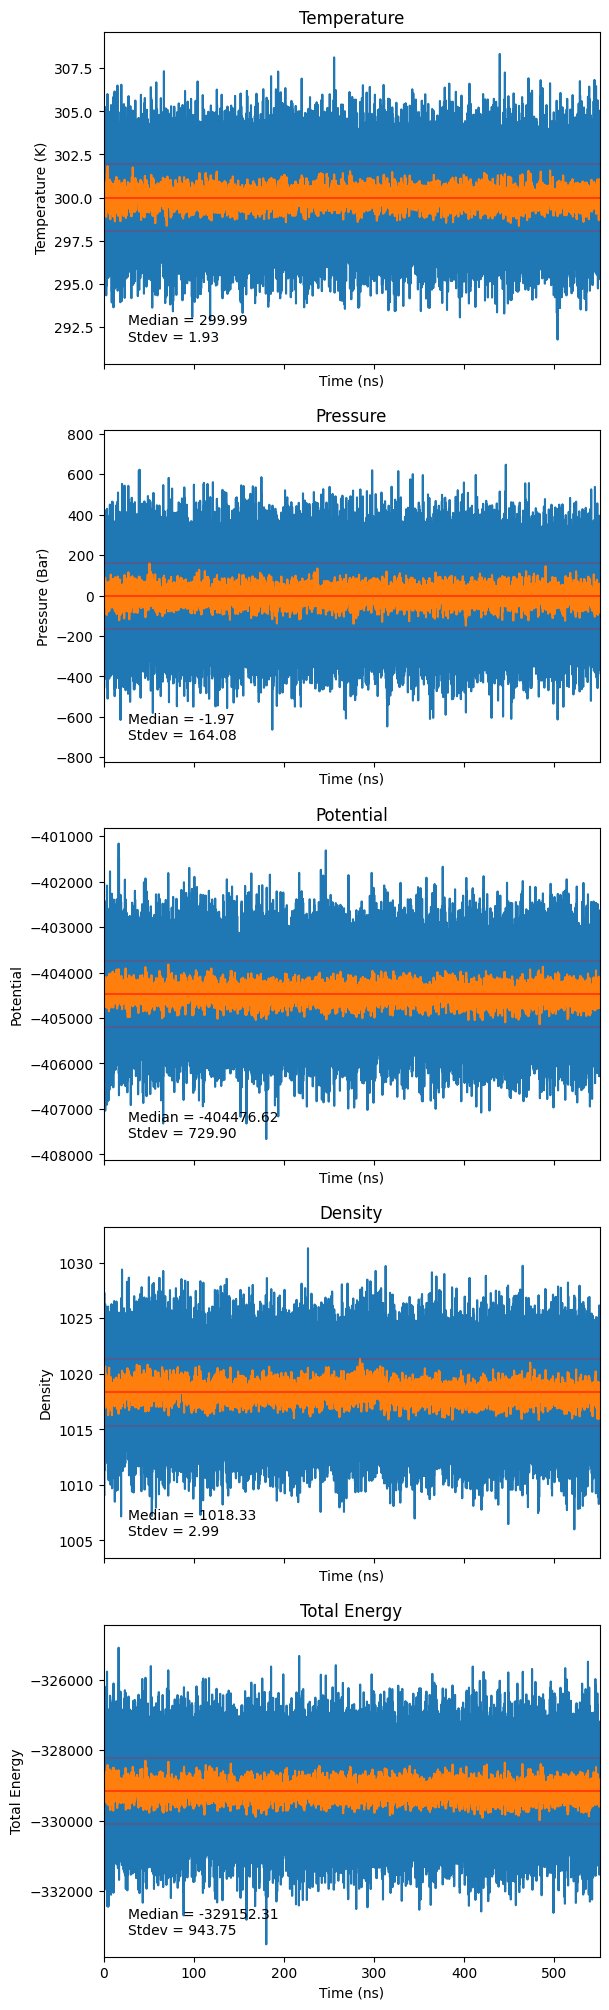

In [7]:
fig, axs = plt.subplots(5, sharex=True)
fig.set(figheight=25)
edr_plot(axs[0],'Temperature', "K")
edr_plot(axs[1],'Pressure', "Bar")
edr_plot(axs[2],'Potential')
edr_plot(axs[3],'Density')
edr_plot(axs[4],'Total Energy')


### Box size

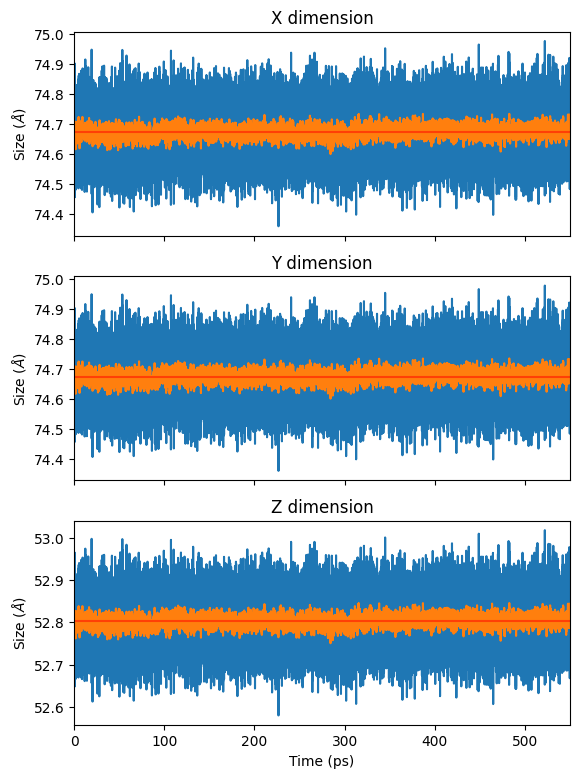

In [8]:
#Get and plot Density data
box_X_data = energy_like_terms.get_data('Box-X')
box_Y_data = energy_like_terms.get_data('Box-Y')
box_Z_data = energy_like_terms.get_data('Box-Z')

fig, axs = plt.subplots(3, sharex=True)
axs[0].plot(box_X_data['Time']/1000, box_X_data['Box-X'])
plt_smooth(axs[0],box_X_data['Box-X'],box_X_data['Time'],20)
plt_median(axs[0],box_X_data['Box-X'], positive=False, negative=False)
axs[0].set_title("X dimension")

axs[1].plot(box_Y_data['Time']/1000, box_Y_data['Box-Y'])
plt_smooth(axs[1],box_Y_data['Box-Y'],box_Y_data['Time'],20)
plt_median(axs[1],box_Y_data['Box-Y'], positive=False, negative=False)
axs[1].set_title("Y dimension")

axs[2].plot(box_Z_data['Time']/1000, box_Z_data['Box-Z'])
plt_smooth(axs[2],box_Z_data['Box-Z'],box_X_data['Time'],20)
plt_median(axs[2],box_Z_data['Box-Z'], positive=False, negative=False)
axs[2].set_title("Z dimension")
axs[2].set(xlabel='Time (ps)')

for ax in axs:
    ax.set(ylabel='Size ($\AA$)', xlim=(0, len(box_Z_data['Time'])/100))
    


fig.set(figheight=9)

# Set axis limits
plt.xlim(0, len(box_Z_data['Time'])/100)
plt.show()

## View the simulation

In [23]:
# Open an NGLView widget
view = nglview.show_mdanalysis(atomistic_system, default_representation=False)

# Add the atomistic system to the widget
view.add_representation('cartoon', selection='protein')


# Draw a licorice representation of the ligand
#view.add_representation('licorice', selection='water')

# Add spacefill representtaion for the ions (Potassium, Chloride)
view.add_representation('spacefill', selection='.POT .CLA', opacity=0.5)

# Center the view
if ligand_name:
    view.center(ligand_name)
    view.add_representation('licorice', selection= ligand_name )
else:
    view.center('protein')

# Set the view to orthographic
view.camera = 'orthographic'

# Show the view in the widget
view

NGLWidget(max_frame=55000)

## Analysis

### Radius of gyration

In [10]:
if radius_of_gyration.value:
   Rgyr = []
   protein = atomistic_system.select_atoms("protein")
   for ts in atomistic_system.trajectory:
      Rgyr.append((atomistic_system.trajectory.time, protein.radius_of_gyration()))
   
   radius = np.array(Rgyr)
   radius = radius.T

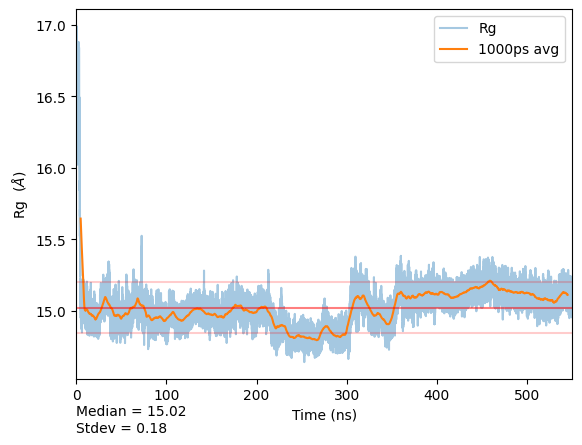

In [11]:
if radius_of_gyration.value:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(radius[0]/1000, radius[1], label='Rg', alpha = 0.4)
    # Add axis labels
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Rg  ($\AA$)')

    # Set axis limits
    ax.set_xlim(0, len(radius.T)/100 )

    # plt median and + 1 stdev
    if len(radius[0]) > 1000:
        factor = 1000
    else:
        factor = 10
   
    plt_smooth(ax,radius[1], radius[0],factor)
    plt_median(ax, radius[1], label=True)

    # Show legend
    plt.legend()
    # Show plot
    plt.show()

### RMSD
Measure RMS deviation from the original structure during the simulation time


In [12]:
if calculate_RMSD.value:
    grouplist =[]
    for group in RMSD_groups:
        grouplist.append(f"protein and name CA and resid {group}")

    # Calculate RMSD using the MDAnalysis functionality
    ref_structure = reference_structure

    # Input: simulation trajectory, reference structure, atoms to superimpose, atoms to calculate the RMSD for
    RMSD = rms.RMSD(atomistic_system,      # Trajectory
                    ref_structure,         # Reference structure
                    select="protein and name CA",   #residus selection for superimposition     
                    groupselections = grouplist)  # RMSD groups
    # Run RMSD analysis
    RMSD.run(verbose=True)

  0%|          | 0/55001 [00:00<?, ?it/s]

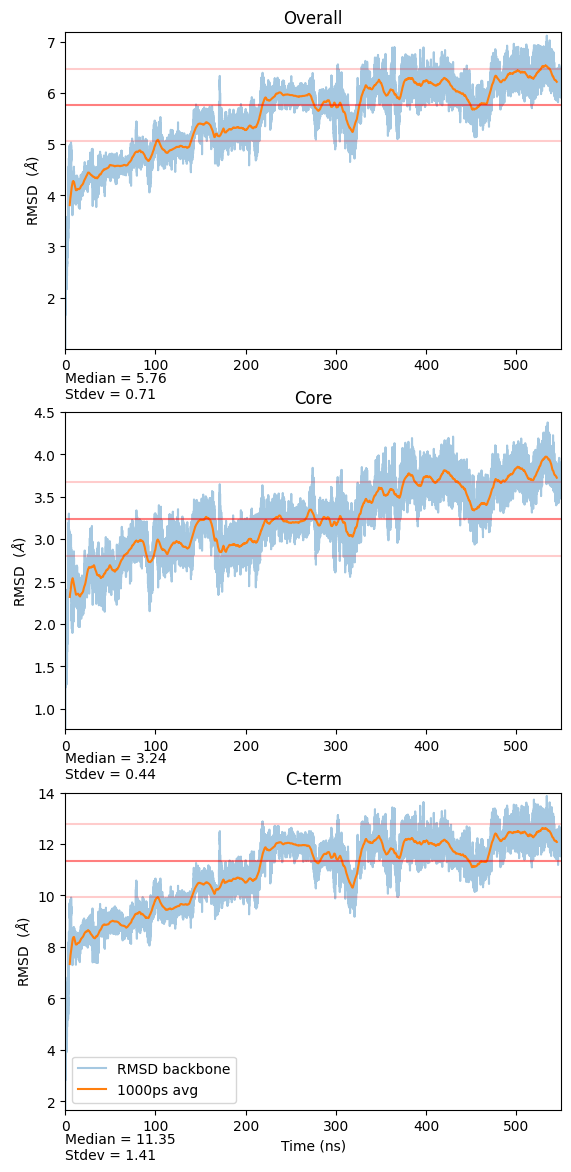

In [13]:
if calculate_RMSD.value:
    #Option to start the plot at specific time (cut of first ms of equilibration)
    plot_0 = 0

    # Extract data for plotting
    rmsd = RMSD.results.rmsd.T  #T = transpose
    # Extract the time data from the RMSD output. Divide by 1000 to get time in ns
    time = rmsd[1]/1000
    
    # Generate plot for each set of RMSD
    n = 2
    fig, axs = plt.subplots(len(RMSD_groups)+1)
    
    for ax in axs:
        ax.plot(time, rmsd[n],  label="RMSD backbone", alpha=0.4)

        if len(rmsd[1]) > 10000:
            plt_smooth(ax,rmsd[n],rmsd[1],1000)
        else:
            plt_smooth(ax,rmsd[n],rmsd[1],20)

        #smoothed and median + stddev view
        plt_median(ax,rmsd[n],label=True)

        # Add axis labels
        ax.set_ylabel("RMSD  ($\AA$)")

        ax.set_title(RMSD_groups_name[n-2])

        # Set axis limits
        ax.set_xlim(plot_0,len(rmsd[n])/100)
        ax.set_ylim(min(rmsd[n][plot_0+2:]),round(max(rmsd[n]),1)+0.1)
        n = n + 1 

    axs[-1].set_xlabel("Time (ns)")
    # Add legend
    plt.legend()
    fig.set(figheight=14)
    # Show the plot
    plt.show()

### Pairwise RMSD

In [14]:
if pairwise_RMSD.value:
    aligner = align.AlignTraj(atomistic_system, atomistic_system, select='name CA',in_memory=False,filename="tmp.xtc")
    aligner.run(verbose=True)

    aligned_atomistic_system = mda.Universe(sim_path + coordinate_file_name,"tmp.xtc")
    matrix = diffusionmap.DistanceMatrix(aligned_atomistic_system, select='name CA')
    matrix.run(verbose=True)
    print(matrix.results.dist_matrix.shape)

In [15]:
if pairwise_RMSD.value:
    plt.imshow(matrix.dist_matrix, cmap='viridis')
    plt.xlabel('Frame')
    plt.ylabel('Frame')
    plt.colorbar(label=r'RMSD ($\AA$)')



### RMSF
Calculate RMS fluctuation per residues from an <b>average structure</b>.

In [16]:
# Generate an average structure
if calculate_RMSF.value:
    
    if not is_aligned:
        do_trajectory_CAalignement()
        atomistic_system = mda.Universe(sim_path + coordinate_file_name, sim_path + trajectory_file_name.split(".")[0] + "_aligned.xtc")
        is_aligned = True
     
#Run RMSF analysis
    C_alphas = atomistic_system.select_atoms('protein and name CA')
    print("Run RMSF calculation")
    RMSF = rms.RMSF(C_alphas)
    RMSF.run(verbose=True)

Run RMSF calculation


  0%|          | 0/55001 [00:00<?, ?it/s]

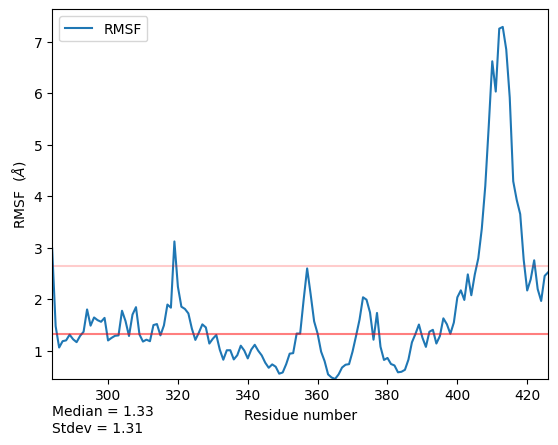

In [17]:
if RMSF:
    # Plot the data - RMSF against residue index
    fig, ax = plt.subplots()

    ax.plot(C_alphas.resids, RMSF.results.rmsf, label='RMSF')
    # Add axis labels
    ax.set_xlabel('Residue number')
    ax.set_ylabel('RMSF  ($\AA$)')

    # Set axis limits
    ax.set_xlim(C_alphas.resids[0], C_alphas.resids[-1] )
    ax.set_ylim(min(RMSF.results.rmsf))

    # plt median and + 1 stdev
    plt_median(ax, RMSF.results.rmsf, negative=False, label=True)


    # Show legend
    plt.legend()
    # Show plot
    plt.show()

In [18]:
if RMSF:
    # dynamically add new attributes
    # ('tempfactors' is pre-defined and filled with zeros as default values)
    atomistic_system.add_TopologyAttr('tempfactors')
    C_alphas.tempfactors = RMSF.results.rmsf


#write PDB file with RMS as B factore
    if ligand_name:
        write_group = atomistic_system.select_atoms(f"(protein and name CA) or resname {ligand_name}")
    else:
        write_group = C_alphas

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        write_group.write(sim_path + sim_name +  "_RMSF.pdb")


## H-Bonds

In [19]:
hbonds = False
if H_bonds and ligand_name:
    from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
    hbonds = HBA(universe=atomistic_system, between=["protein", f"resname {ligand_name}"])

# Guess H and accepetors
    protein_H = hbonds.guess_hydrogens("protein")
    protein_acc = hbonds.guess_acceptors("protein")
    ligand_H = hbonds.guess_hydrogens(f"resname  {ligand_name}")
    ligand_acc =  hbonds.guess_acceptors(f"resname {ligand_name}")

    hbonds.hydrogens_sel = f"({protein_H}) or ({ligand_H})"
    hbonds.acceptors_sel = f"({protein_acc}) or ({ligand_acc})"

    hbonds.run(verbose=True, start=start_frame, stop=stop_frame)

In [20]:
if hbonds:
    print(hbonds.results.hbonds.shape)

    plt.plot(hbonds.times, hbonds.count_by_time(), lw=2)

    plt.title("Number of hydrogon bonds over time", weight="bold")
    plt.xlabel("Time (ps)")
    plt.ylabel(r"$N_{HB}$")

    plt.show()

In [21]:
if hbonds:
    for donor, acceptor, count in hbonds.count_by_type():

        donor_resname, donor_type = donor.split(":")
        n_donors = atomistic_system.select_atoms(f"resname {donor_resname} and type {donor_type}").n_atoms

        # average number of hbonds per donor molecule per frame
        mean_count = 2 * int(count) / (hbonds.n_frames * n_donors)  # multiply by two as each hydrogen bond involves two water molecules
        print(f"{donor} to {acceptor}: {mean_count:.2f}")